In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Regression models

First let's load in the data:

In [30]:
bikeshare = pd.read_csv('../EDA/bikeshare_train_data.csv', parse_dates=['Date'],index_col=['Date'])

In [31]:
bikeshare.sample(5)

,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips
Date,,,,,,,,,,,,,,,,,,,,
2017-07-02,968.266667,12.8,23.9,18.4,11.1,0.0,0.4,0.0,0.0,0.0,0.0,2.0,26.971974,26.631044,26.801509,10721106.00,5104247.0,0.0,3247,4565.333252
2021-01-29,557.150000,2.5,7.0,4.8,4.5,13.2,0.0,0.0,0.0,0.0,0.0,0.0,8.511893,9.515699,9.013796,2559287.00,1283589.0,0.0,1051,2089.373377
2019-01-13,515.133333,0.8,8.7,4.8,7.9,13.2,0.0,0.0,0.0,0.0,0.0,0.0,10.725634,10.907877,10.816756,4878983.34,2062101.0,0.0,1498,2210.318917
2019-09-19,742.200000,9.2,15.8,12.5,6.6,5.5,0.0,1.2,0.0,1.2,0.0,0.0,16.526480,17.296642,16.911561,7300622.67,3495181.0,0.0,2889,3692.686893
2023-04-04,784.216667,1.7,10.7,6.2,9.0,11.8,0.0,0.0,0.0,0.0,0.0,0.0,9.905309,10.291850,10.098580,7577683.00,17626782.0,812.0,2957,2453.684367


Recall that the features are defined as:

- ``day_length``: The number of minutes from sunrise to sunset for the given day
- ``min_temp``: The daily minimum temperature (deg C)
- ``max_temp``: The daily maximum temperature (deg C)
- ``mean_temp``: The mean temperature of the day (deg C)
- ``temp_diff``: The difference between the daily minimum and maximum temperatures (deg C)
- ``hdd``: The "Heating Degree Days" of the day, the number of degrees C that the daily average temperature is below 18 degrees C (0 if the daily average temperature is above 18 degrees C)
- ``cdd``: The "Cooling Degree Days" of the day, the number of degrees C that the daily average temperature is above 18 degrees C (0 if the daily average temperature is below 18 degrees C)
- ``rain``: The amount of rain that occurred that day (mm)
- ``snow``: The amount of snow that occurred that day (cm)
- ``total_precip``: The total amount of rain and snow that occurred that day (mm) (Note: the standard conversion of snow-to-rain amount is a factor of ten, so 1cm of snow is equivalent to 1mm of rain; therefore, this column is exactly the sum of ``rain`` and ``snow``)
- ``snow_on_ground``: The amount of snow observed on the ground during the day (cm)
- ``max_gust``: The difference between the speed of the observed maximum gust of wind (in km/hr) and 31 km/hr (0 if the maximum observed gust of wind is at or below 31 km/hr)
- ``mean_dep_temp``: The mean departure temperature of all bike rides taken that day (deg C)
- ``mean_ret_temp``: The mean return temperature of all bike rides taken that day (deg C)
- ``total_dist``: The total distance covered by all bike rides taken that day (m)
- ``total_duration``: The total time spent on bikes that day (sec)
- ``ebike_trips``: The number of bike rides taken on electric bikes that day
- ``num_trips`` The total number of bike rides taken that day, regardless of bicycle type
- In the notebook ``EDA.ipynb`` we added another column, ``adj_num_trips``, that are the number of trips with baseline bikeshare demand removed. We may also have more columns that are other detrended versions of ``num_trips``.

We aim to predict this adjusted number of trips, and then later convert these into actual predicted ``num_trips``.

In ``EDA.ipynb`` we used correlation matrices, plots, and lasso regression to perform some feature selection and handle some collinearity issues between columns. As such the features we will focus on in this notebook are
- ``day_length``,
- ``max_temp``,
- ``temp_diff``,
- ``total_precip``,
- ``snow_on_ground``, and
- ``max_gust``.

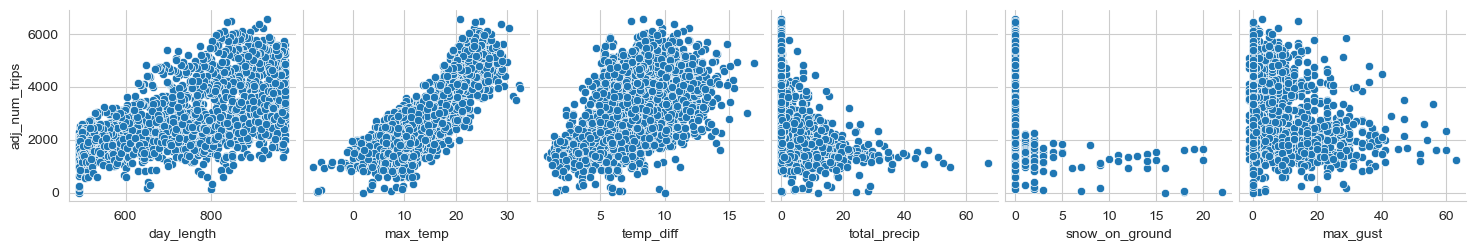

In [32]:
features = ['day_length','max_temp','temp_diff','total_precip','snow_on_ground','max_gust']
##Target variable name, this should be a column of the bikeshare-weather data csv that has a version of detrending applied to it
target = 'adj_num_trips'
sns.pairplot(data=bikeshare,
             x_vars=features,
            y_vars=[target])

plt.show()

Some initial thoughts:
- ``max_temp`` probably depends on ``day_length`` in some way so we should probably include an interaction term for these two features,
- Much of ``snow_on_ground`` is zero (and when nonzero has a pretty "small" distribution of values) so including or excluding this term in a model likely won't affect performance much, and
- ``max_gust`` and ``temp_diff`` look too scattered that it's possible they don't make it into the final model.

In any case, we only have six features under consideration. We can perform best subsets selection on these six features and then if some of the higher-performing subsets include ``day_length`` and ``max_temp`` we can compare those models' performances to one including an interaction term (we could do this in the other order--i.e., including the interaction, doing best subsets selection, then throwing away models that include the interaction term but not both the others, but our way has a shorter runtime).

In [33]:
# This returns the power set of a set minus the empty set. (Copied from a lecture notebook from this bootcamp)
# Credit to Erdős alumni Nadir Hajouji for greatly simplifying this function!

def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

In [34]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [35]:
n_splits = 5
kfold = KFold(n_splits,
              shuffle=True,
              random_state=604)

In [36]:
scaler = StandardScaler().set_output(transform='pandas')
bikeshare_scaled = scaler.fit_transform(bikeshare[features])
bikeshare_scaled[target] = bikeshare[target]

Before we look at best subsets let us look at just the mean ``adj_num_trips`` and its RMSE for a baseline to compare to; at this stage our only comparison is the base demand trend from ``EDA.ipynb``.

In [45]:
avg_num_trips = bikeshare[target].mean()
baseline_rmse = np.sqrt(mean_squared_error(bikeshare[target], np.ones(len(bikeshare))*avg_num_trips))
print("Using the average number of detrended trips as a constant prediction has a RMSE of", baseline_rmse)

Using the average number of detrended trips as a constant prediction has a RMSE of 1253.2254261884534


In [38]:
models = powerset(features)
rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bikeshare_scaled)):
    bike_tt = bikeshare_scaled.iloc[train_index]
    bike_ho = bikeshare_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

In [39]:
avg_rmses = np.mean(rmses, axis=0)
print(avg_rmses)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

[ 923.15487746  662.387958    662.69899167 1035.11272126  832.60284318
  635.27745706  635.52504646 1131.92361896  862.59227131  585.76894418
  585.44688727 1000.75154614  808.67279267  580.7866781   580.60094499
 1231.79343239  915.73380015  661.93058794  662.25719572 1017.52151879
  824.87854479  635.40103111  635.6512709  1117.65351572  857.49811081
  584.5807828   584.00413206  985.98598147  802.17659897  580.1362042
  579.76995029 1225.58757288  911.72937535  649.12577921  649.42591315
 1030.65014997  830.40273639  628.45770077  628.70974341 1126.26848773
  860.90348174  583.78538776  583.30398739 1000.34744133  809.02210775
  579.67481784  579.34643744 1202.73212225  903.65101235  648.8664887
  649.1706905  1012.69147214  822.45990293  628.61750011  628.87052066
 1110.95629172  855.3448278   582.66831048  581.94071893  985.18244164
  802.34982322  579.02004184  578.51185927]
The models have average cross-validation RMSEs ranging from 578.5118592746056 to 1231.793432388038
The mod

That's all the features (although we can see that there are certain other models that also perform similarly that use subsets of these features). Let's compare this performance to best subsets where all models include ``day_length``, ``max_temp``, and an interaction term between them:

In [40]:
bikeshare_scaled['day_length_x_max_temp'] = bikeshare_scaled.day_length * bikeshare_scaled.max_temp

In [41]:
base_features = ['day_length','max_temp','day_length_x_max_temp']
remaining_features = ['temp_diff', 'total_precip', 'snow_on_ground', 'max_gust']
models = [base_features + subset for subset in powerset(remaining_features)]

rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bikeshare_scaled)):
    bike_tt = bikeshare_scaled.iloc[train_index]
    bike_ho = bikeshare_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

avg_rmses = np.mean(rmses,axis=0)
print(avg_rmses)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

[623.6430185  574.52885008 570.72143843 647.50236216 623.53757688
 574.45558668 570.77392671 637.45386389 618.67796575 573.34436229
 570.15212242 637.51769353 618.64714157 573.24681588 570.17651321]
The models have average cross-validation RMSEs ranging from 570.152122422274 to 647.5023621643262
The model with the minimum average cross-validation RMSE of 570.152122422274 uses the features ['day_length', 'max_temp', 'day_length_x_max_temp', 'temp_diff', 'total_precip', 'max_gust']


### Performance Discussion and Visualization

#### [NOTE: This section was written when ``adj_num_trips`` is adjusted by a degree-3 polynomial. It may require editing once a detrending is chosen.]

The best-performing linear regression for ``adj_num_trips`` occurs on the features  ``day_length``, ``max_temp``, ``day_length_x_max_temp``, ``temp_diff``, ``total_precip``, and ``max_gust``, with an average cross-validation RMSE of ``570.1521``.

Let's look at a plot with these predictions on the daily timescale.

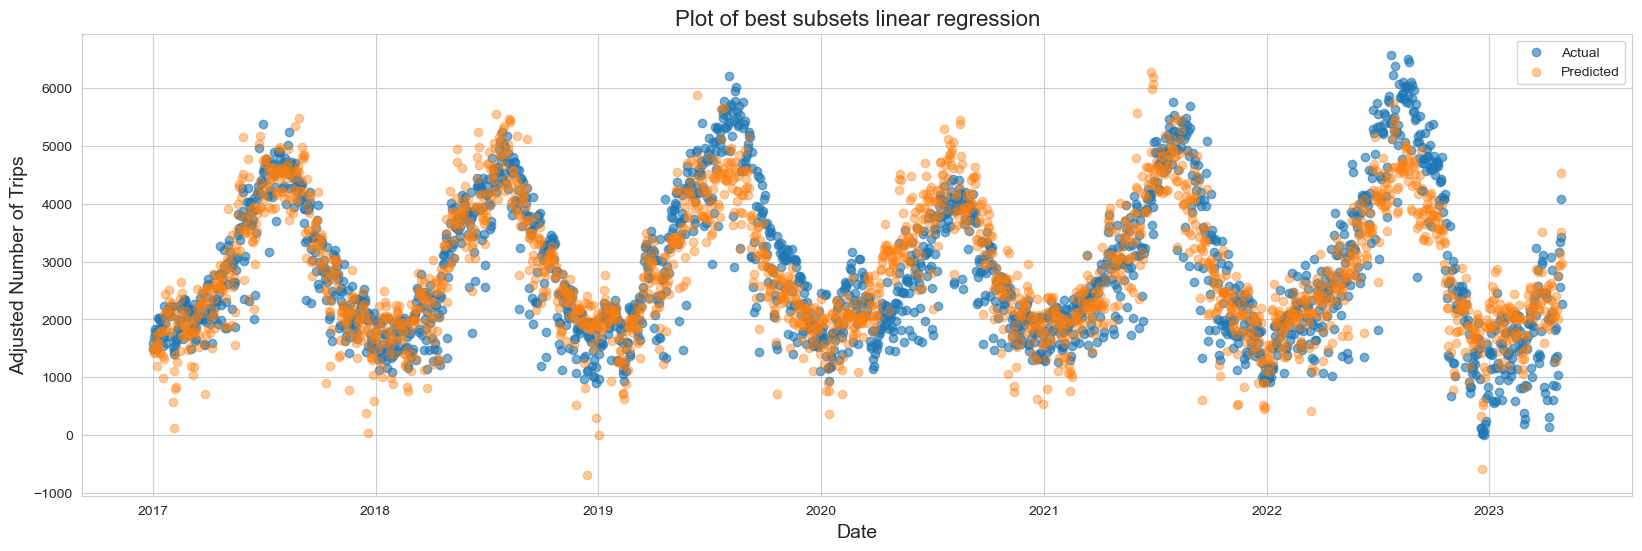

In [42]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.index,
           bikeshare[target],
           alpha=0.6,
           label='Actual')

reg_bestsubset = LinearRegression()
reg_bestsubset.fit(bikeshare_scaled[['day_length', 'max_temp', 'day_length_x_max_temp', 'temp_diff', 'total_precip', 'max_gust']],
                   bikeshare[target])
preds_bestsubset = reg_bestsubset.predict(bikeshare_scaled[['day_length', 'max_temp', 'day_length_x_max_temp', 'temp_diff', 'total_precip', 'max_gust']])

plt.scatter(bikeshare.index.values,
           preds_bestsubset,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression',fontsize=16)
plt.legend()

plt.show()

We can see that we have four main regions where the error is most apparent:
- The peak of summer 2019,
- The peak of summer 2022,
- COVID's outbreak, and
- Winter 2023.

Looking at the following plots below we can see that, comparatively to other years where our predictions look closer to the true values, the weather patterns in these pockets are not much different than those in other years. This suggests that our predictions' error is due to factors unrelated to the weather.

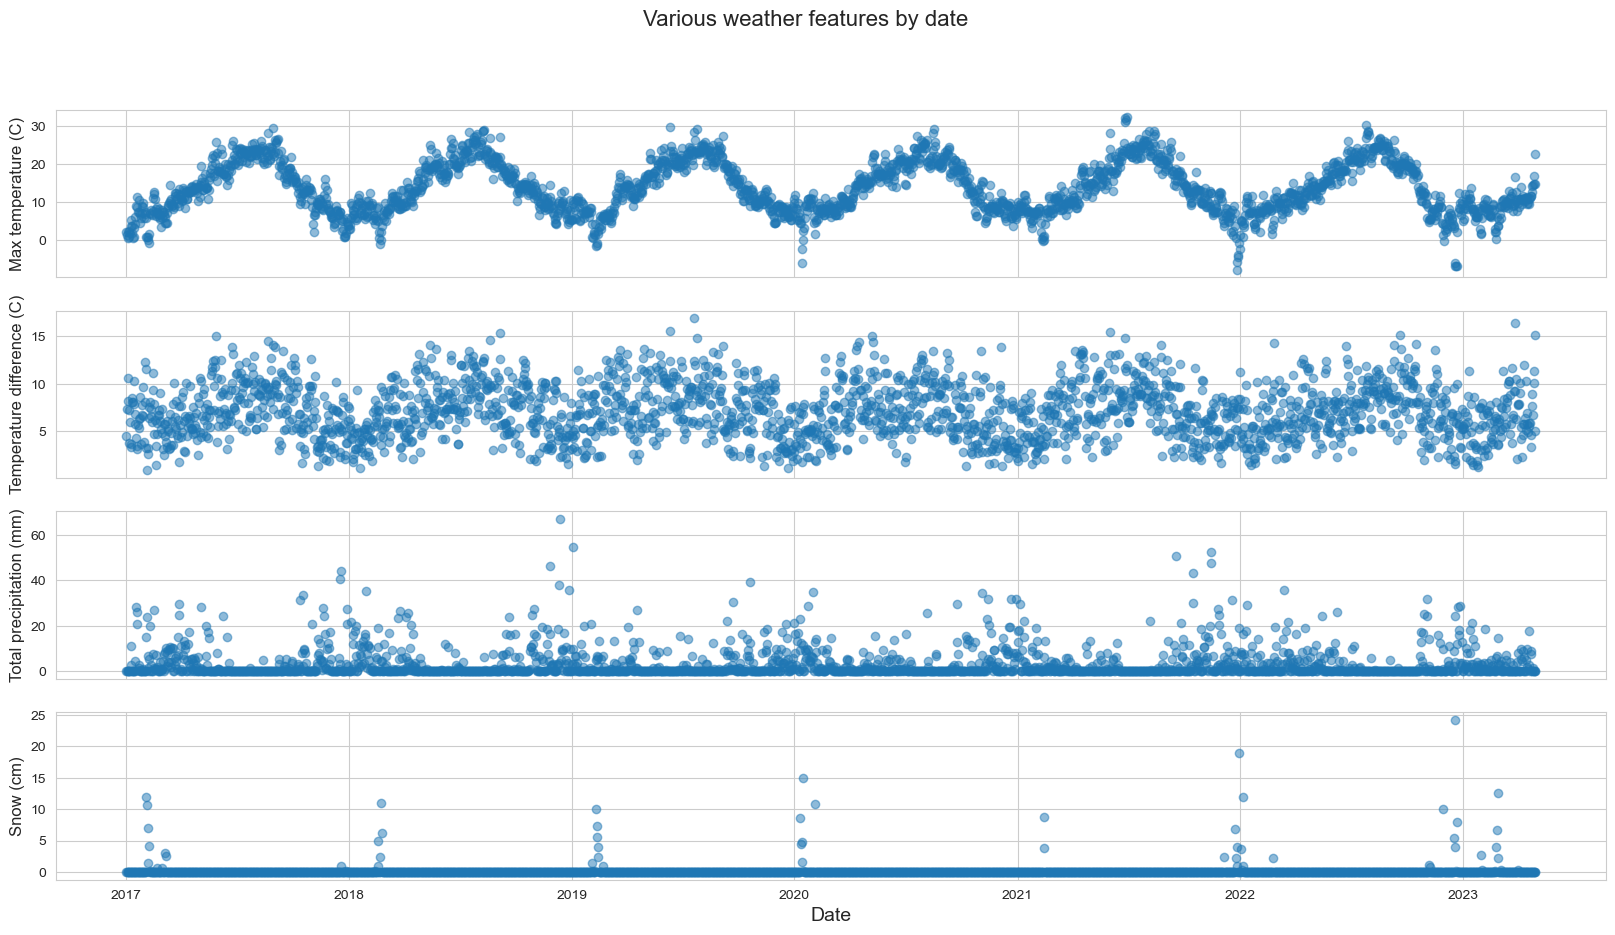

In [43]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex = True, figsize=(20,10))

plt.suptitle('Various weather features by date',fontsize=16)

ax[0].scatter(bikeshare.index,
           bikeshare.max_temp,
           alpha=0.5)
ax[0].set_ylabel('Max temperature (C)', fontsize=12)

ax[1].scatter(bikeshare.index,
           bikeshare.temp_diff,
           alpha=0.5)
ax[1].set_ylabel('Temperature difference (C)',fontsize=12)

ax[2].scatter(bikeshare.index,
           bikeshare.total_precip,
           alpha=0.5)
ax[2].set_ylabel('Total precipitation (mm)',fontsize=12)

ax[3].scatter(bikeshare.index,
           bikeshare.snow,
           alpha=0.5)
ax[3].set_ylabel('Snow (cm)',fontsize=12)

plt.xlabel('Date', fontsize=14)

plt.show()

Lastly a plot of residuals:

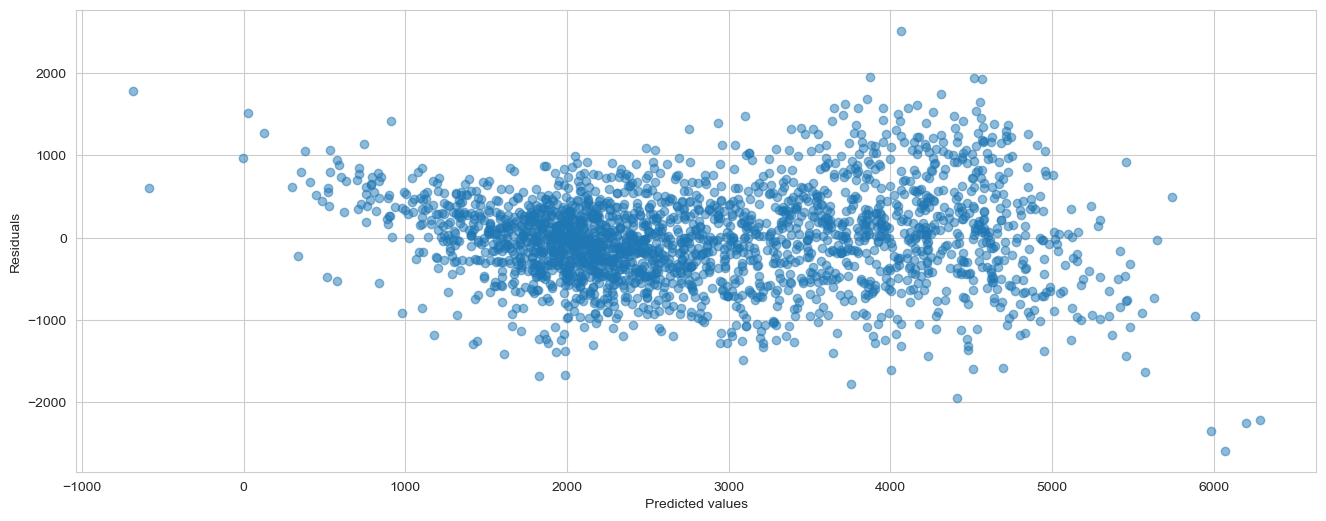

In [44]:
residuals = bikeshare[target] - preds_bestsubset

plt.figure(figsize=(16,6))

plt.scatter(preds_bestsubset,
           residuals,
           alpha=0.5)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.show()

While it doesn't quite look like we missed any significant signals or functional relationships (although it might be argued that this plot actually bears a resemblance to a reflection of the degree-3 polynomial base demand curve obtained in ``EDA.ipynb``) we can see that for higher predicted values the residuals have a larger range of possible values. While we may be able to rectify this with a different weighting to our regression it seems more reasonable to say that the assumptions of linear regression likely don't hold in our situation.